<a href="https://colab.research.google.com/github/simonetome/ApplieAI-Biomedicine-Masciulli-Pietrobon-Tome/blob/main/DWTResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this notebook is to show performances augmenting samples of the imbalanced class with random gaussian noise of zero mean and variance 0.05 as suggested in DOI: 10.1155/2020/3215681

In [ ]:
!pip install heartpy
!pip install PyWavelets

In [1]:
import os 
import zipfile 
from scipy.io import loadmat 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import io
from PIL import Image
import tensorflow as tf 
from tensorflow import keras
import sys
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import heartpy as hp
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import pywt as pw
from scipy.signal import detrend
SEED = 1
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [ ]:
#IF Colab cloud GPU used -> Mount the My Drive folder and set cwd
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/FinalAssignment'
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_current_folder = "training_set.zip" # where the zip is
dataset_folder = "C://Users//simon//Desktop//AppliedAI-project" # where I want the dataset - avoid the current folder as Git doesn't allow huge uploads

with zipfile.ZipFile(dataset_current_folder, 'r') as zip: # extract the zip file into the desired folder 
    zip.extractall(dataset_folder)

FileNotFoundError: ignored

In [2]:
#IF local runtime used -> Set os.cwd as google drive volume , mounted locally
os.chdir('G:\Il mio Drive')
cwd = os.getcwd()
cwd = os.path.join(cwd,'Colab2022/AppliedAI/FinalAssignment')
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

In [3]:
def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
    label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
    peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
    signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
    if os.path.isfile(label_filepath):
        mat_file = loadmat(label_filepath)
        label = np.asarray(mat_file['labels'])
    if os.path.isfile(peak_filepath):
        mat_file = loadmat(peak_filepath)
        peaks = np.array(mat_file['rpeaks'],dtype=np.int64)
    if os.path.isfile(signal_filepath):
        mat_file = loadmat(signal_filepath)
        signal = np.asarray(mat_file['ecg'] )

    return label, peaks, signal

labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))


In [4]:
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

for signal in ecg_signals:
    first_lead_signals.append(signal[:,0].tolist())    # converting the array to list as list of array is deprecated 
    second_lead_signals.append(signal[:,1].tolist())

df = pd.DataFrame(data =[ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]).T
df.columns = cols

# transform peaks 
for id in tqdm(df.index.tolist()):
    peaks = df.iloc[id]['peaks']
    p_list = list()
    for p in peaks:
        p_list.append(p[0])
    df.iloc[id]['peaks'] = np.asarray(p_list).astype(np.int64)

df.head()

100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 1120.48it/s]


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S010,"[1.56, 0.92, 0.28, -0.36, -0.29, -0.2, -0.19, ...","[-5.12, -4.485, -3.85, -3.215, -2.58, -1.945, ...","[96, 169, 268, 360, 427, 539, 634, 714, 789, 8...",128,"[N, V, N, N, V, N, N, V, N, N, V, N, N, V, N, ..."
1,S009,"[0.27, 0.57, 0.36, -0.28, -0.39, -0.32, -0.37,...","[-0.43, -0.93, -1.48, -1.36, -0.82, -0.36, -0....","[105, 205, 262, 410, 510, 611, 667, 812, 917, ...",128,"[N, N, V, N, N, N, V, N, N, N, V, N, N, N, V, ..."
2,S008,"[0.405, 0.42, 0.415, 0.43, 0.415, 0.41, 0.445,...","[-0.32, -0.345, -0.325, -0.37, -0.385, -0.42, ...","[71, 153, 232, 280, 367, 419, 537, 632, 682, 8...",128,"[N, N, N, S, N, S, N, N, S, N, N, S, N, V, N, ..."
3,S007,"[0.145, 0.125, 0.145, 0.145, 0.145, 0.145, 0.1...","[-0.635, -0.745, -0.735, -0.695, -0.685, -0.68...","[49, 129, 216, 298, 380, 466, 550, 631, 719, 8...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S006,"[0.33, 0.31, 0.32, 0.28, 0.25, 0.22, 0.15, 0.1...","[0.27, 0.24, 0.23, 0.18, 0.16, 0.14, 0.09, 0.0...","[67, 170, 278, 386, 492, 602, 662, 811, 886, 1...",128,"[N, N, N, N, N, N, V, N, V, N, V, N, V, N, V, ..."


In [5]:
# downsampling signal 
from scipy.signal import resample

ids_128 = df[df['frequencies'] == 128].index.tolist() 
ids_250 = df[df['frequencies'] == 250].index.tolist() 
resampled_len = len(df.iloc[ids_128[0]]['ecg_lead_1'])
sampled_len = len(df.iloc[ids_250[0]]['ecg_lead_1'])


for id in tqdm(ids_250):
    row = df.iloc[id]
    # first lead
    signal = np.asarray(row['ecg_lead_1']).astype(np.float32)
    resampled_1 = resample(signal,resampled_len)
    
    # second lead
    signal = np.asarray(row['ecg_lead_2']).astype(np.float32)
    resampled_2 = resample(signal,resampled_len)
    
    df.iloc[id]['ecg_lead_1'] = resampled_1.tolist()
    df.iloc[id]['ecg_lead_2'] = resampled_2.tolist()
    
    for i,p in enumerate(list(df.iloc[id]['peaks'])):
        df.iloc[id]['peaks'][i] = int(resampled_len * p/sampled_len)

df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.41it/s]


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S010,"[1.56, 0.92, 0.28, -0.36, -0.29, -0.2, -0.19, ...","[-5.12, -4.485, -3.85, -3.215, -2.58, -1.945, ...","[96, 169, 268, 360, 427, 539, 634, 714, 789, 8...",128,"[N, V, N, N, V, N, N, V, N, N, V, N, N, V, N, ..."
1,S009,"[0.27, 0.57, 0.36, -0.28, -0.39, -0.32, -0.37,...","[-0.43, -0.93, -1.48, -1.36, -0.82, -0.36, -0....","[105, 205, 262, 410, 510, 611, 667, 812, 917, ...",128,"[N, N, V, N, N, N, V, N, N, N, V, N, N, N, V, ..."
2,S008,"[0.405, 0.42, 0.415, 0.43, 0.415, 0.41, 0.445,...","[-0.32, -0.345, -0.325, -0.37, -0.385, -0.42, ...","[71, 153, 232, 280, 367, 419, 537, 632, 682, 8...",128,"[N, N, N, S, N, S, N, N, S, N, N, S, N, V, N, ..."
3,S007,"[0.145, 0.125, 0.145, 0.145, 0.145, 0.145, 0.1...","[-0.635, -0.745, -0.735, -0.695, -0.685, -0.68...","[49, 129, 216, 298, 380, 466, 550, 631, 719, 8...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S006,"[0.33, 0.31, 0.32, 0.28, 0.25, 0.22, 0.15, 0.1...","[0.27, 0.24, 0.23, 0.18, 0.16, 0.14, 0.09, 0.0...","[67, 170, 278, 386, 492, 602, 662, 811, 886, 1...",128,"[N, N, N, N, N, N, V, N, V, N, V, N, V, N, V, ..."


['N', 'V', 'N', 'N', 'V', 'N', 'N', 'V', 'N', 'N', 'V', 'N', 'N', 'V', 'N', 'S', 'N']


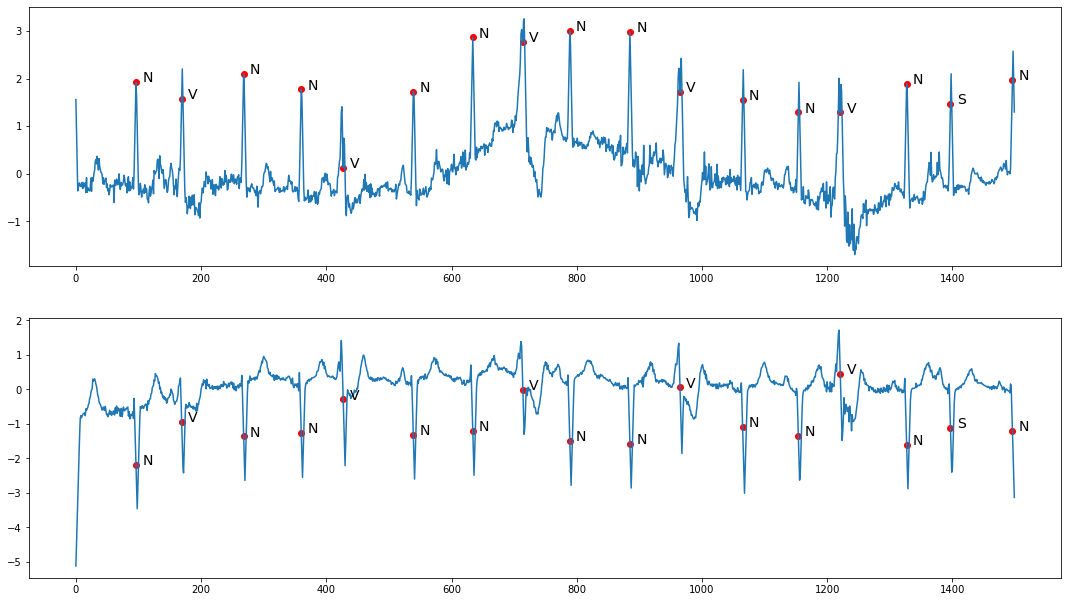

['N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V']


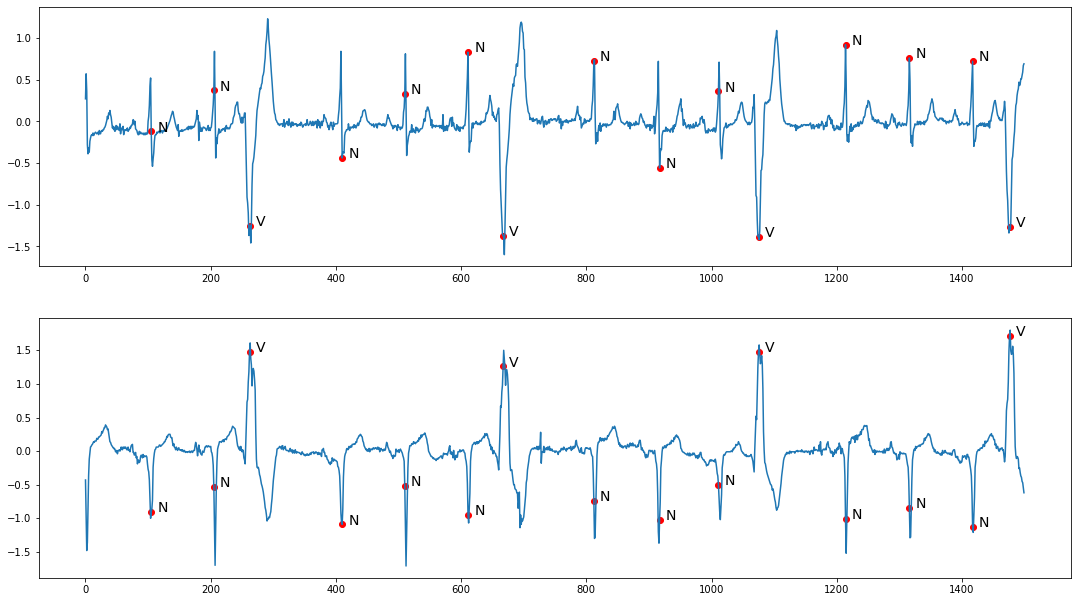

['N', 'N', 'N', 'S', 'N', 'S', 'N', 'N', 'S', 'N', 'N', 'S', 'N', 'V', 'N', 'N', 'N', 'N']


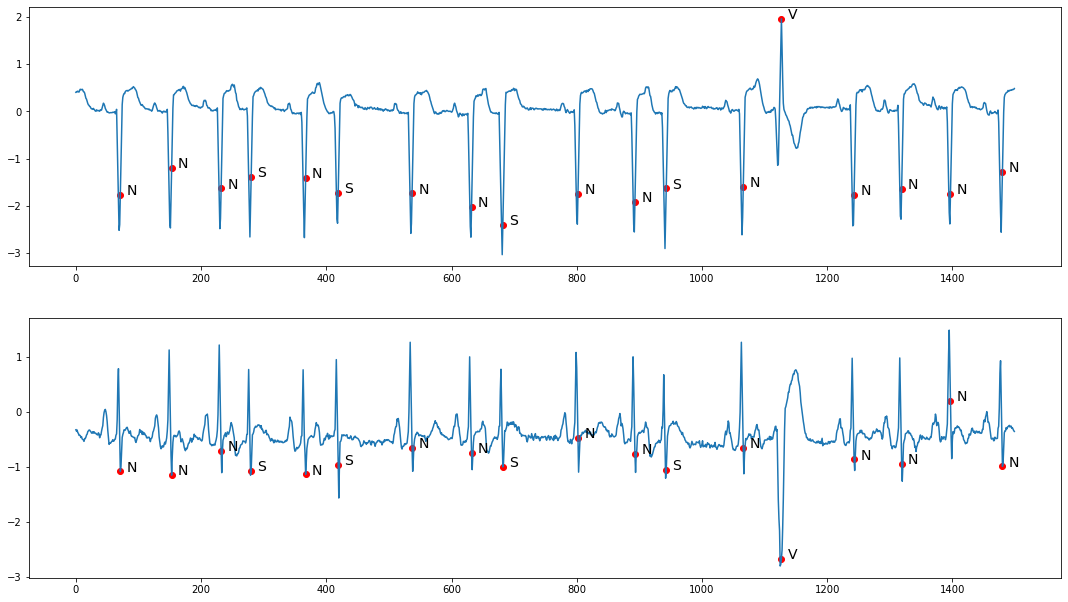

In [6]:
# plot signal 

def plot_signal(df,id,length):
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
    
    signal = df.iloc[id]
    
    first_lead = signal['ecg_lead_1'][:length]
    second_lead = signal['ecg_lead_2'][:length]
    
    peaks_ = signal['peaks']
    labels_ = signal['labels']
    
    x = list(range(length))
    
    ax1.plot(x,first_lead)
    ax2.plot(x,second_lead)
    
    peaks = list()
    p_amplitudes_first = list()
    p_amplitudes_second = list()
    labels = list()
    
    for i,p in enumerate(peaks_):
        if(p <= length):
            peaks.append(p)
            p_amplitudes_first.append(first_lead[p])
            p_amplitudes_second.append(second_lead[p])
            labels.append(labels_[i])
        else:
            break
            
    ax1.scatter(peaks,p_amplitudes_first,color='red')
    ax2.scatter(peaks,p_amplitudes_second,color='red')
    offset = 10
    
    for i, txt in enumerate(labels):
        ax1.annotate(txt, (peaks[i]+offset, p_amplitudes_first[i]),size = 14)
        ax2.annotate(txt, (peaks[i]+offset, p_amplitudes_second[i]),size = 14)
    
    print(labels)
    plt.show()



plot_signal(df,0,1500)
plot_signal(df,1,1500)
plot_signal(df,2,1500)

100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:02<00:00, 40.81it/s]


['N', 'V', 'N', 'N', 'V', 'N', 'N', 'V', 'N', 'N', 'V', 'N', 'N', 'V', 'N', 'S', 'N']


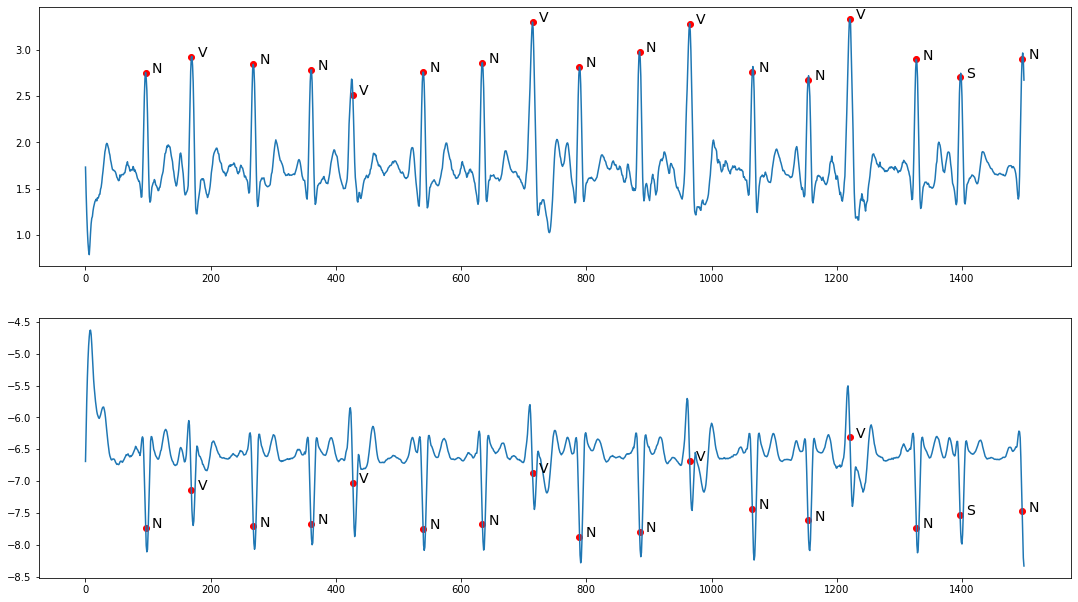

['N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V']


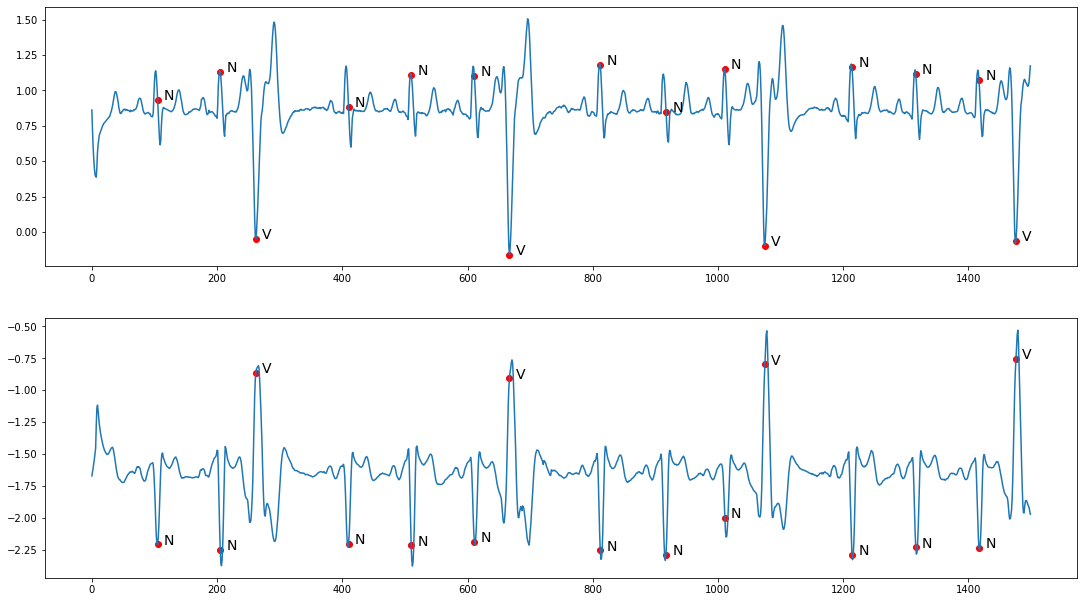

['N', 'N', 'N', 'S', 'N', 'S', 'N', 'N', 'S', 'N', 'N', 'S', 'N', 'V', 'N', 'N', 'N', 'N']


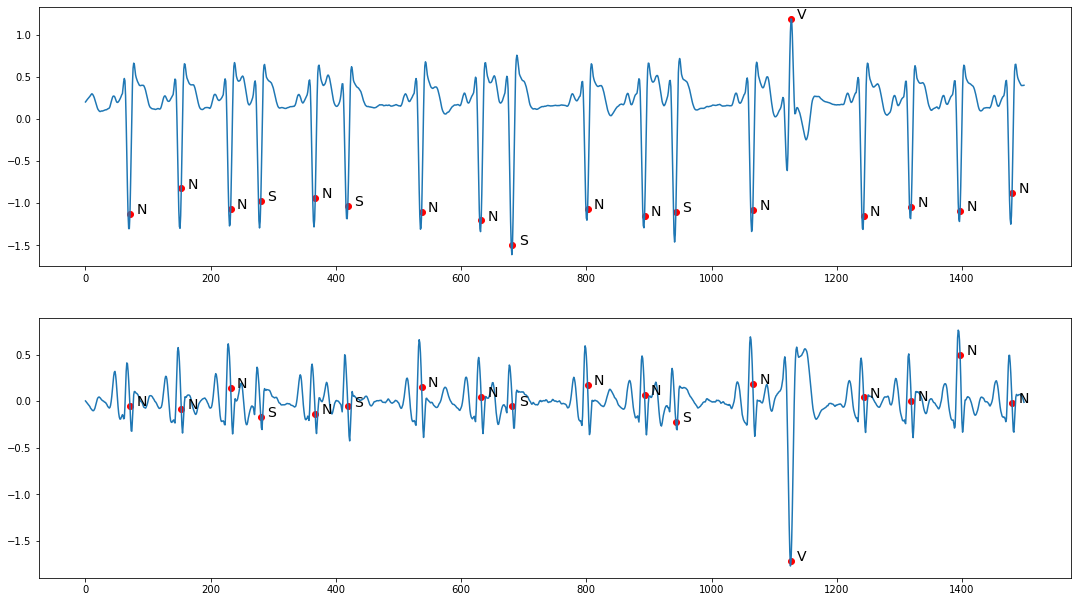

In [7]:
# center signals and remove baseline 
from scipy.signal import detrend
ids = df['sigId'].index
for id in tqdm(ids):
    row = df.iloc[id]
    
    first_sig = np.array(row['ecg_lead_1'])
    second_sig = np.array(row['ecg_lead_2'])
    


    first_sig = hp.smooth_signal(first_sig, 128, window_length=None, polyorder=2)
    first_sig = hp.remove_baseline_wander(first_sig, 128,cutoff=0.01)
    second_sig = hp.smooth_signal(second_sig, 128, window_length=None, polyorder=2)
    second_sig = hp.remove_baseline_wander(second_sig, 128,cutoff=0.01)
    

    # https://swharden.com/blog/2020-09-23-signal-filtering-in-python/
    # create a normalized Hanning window
    #windowSize = 5
    #window = np.hanning(windowSize)
    #window = window / window.sum()
    #first_sig = np.convolve(window, first_sig, mode='same')
    #second_sig = np.convolve(window, second_sig, mode='same')
    #first_sig = (2*((first_sig - first_sig.min())/(first_sig.max()-first_sig.min()))-1).tolist()
    #second_sig = (2*((second_sig - second_sig.min())/(second_sig.max()-second_sig.min()))-1).tolist()

    #first_sig = ((first_sig - first_sig.mean())/(first_sig.std()))#.tolist()
    #second_sig = ((second_sig - second_sig.mean())/(second_sig.std()))#.tolist()
    df.iloc[id]['ecg_lead_1'] = first_sig[:]
    df.iloc[id]['ecg_lead_2'] = second_sig[:]

plot_signal(df,0,1500)
plot_signal(df,1,1500)
plot_signal(df,2,1500)


In [8]:
#DWT

def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.float32)

def create_patch_v2(df):
  dataset_dict = {}
  ids = df.index.tolist()
  offset = 0
  patch_length = 200#200
  for l,id in enumerate(ids):
      print(f"{l}/{len(ids)}",end='\r')
      row =  df.loc[id]

      peaks = row['peaks']
      first_lead_signal = row['ecg_lead_1']
      second_lead_signal = row['ecg_lead_2']  
      #1) Splitting the continuous ECG signal to 10s(1280 samples @128Hz) windows and select a 10s window from an ECG signal.
      for i in range(0, min(len(first_sig), len(second_sig)), 1280):
        first_sig_window = first_sig[i:i+1280]
        second_sig_window = second_sig[i:i+1280]
        #2) Normalizing the amplitude values to the range of between zero and one.
        
        first_sig_std = (2*((first_sig_window - first_sig_window.min())/(first_sig_window.max()-first_sig_window.min()))-1).tolist()
        second_sig_std = (2*((second_sig_window - second_sig_window.min())/(second_sig_window.max()-second_sig_window.min()))-1).tolist()
        ###
        #first_sig_std = hp.remove_baseline_wander(first_sig_std, 128,cutoff=0.05)
        #second_sig_std = hp.remove_baseline_wander(second_sig_std, 128,cutoff=0.05)
        ###
        first_sig[i:i+1280] = first_sig_std
        second_sig[i:i+1280] = second_sig_std         
      if(len(peaks) != len(labels[id])):
          print("ERROR")



      for i,peak in enumerate(peaks):
          index = str(id)+'_'+str(i)
          dataset_dict[index] = {}
          first_lead_patch = list()
          second_lead_patch = list()
          size = list(range(int(peak-patch_length/2)+offset,int(peak+patch_length/2)+offset))
          if(len(size) != patch_length):
              print("error")

          for s in size:
              if(s < 0 or s >= resampled_len):   # padding with 0
                  first_lead_patch.append(0.) 
                  second_lead_patch.append(0.) 
              else:
                  first_lead_patch.append(first_lead_signal[s])
                  second_lead_patch.append(second_lead_signal[s])
          
          dataset_dict[index]["first_lead_dwt_approximation"], dataset_dict[index]["first_lead_dwt_detail"] = pw.dwt(first_lead_patch, 'dmey', mode='constant')
          dataset_dict[index]["second_lead_dwt_approximation"], dataset_dict[index]["second_lead_dwt_detail"] = pw.dwt(second_lead_patch, 'dmey', mode='constant')

          dataset_dict[index]["stringLabel"] = labels[id][i]
          dataset_dict[index]["label"] = convert_to_one_hot(labels[id][i])


  dataset_df = pd.DataFrame.from_dict(dataset_dict,orient='index')
  return dataset_df   

classes = np.array(["N","S","V"])
validation_percentage = 0.2
training_df, validation_df = train_test_split(df,test_size = validation_percentage,random_state=SEED)
training_patches_df = create_patch_v2(training_df)
validation_patches_df = create_patch_v2(validation_df)
validation_patches_df

,first_lead_dwt_approximation,first_lead_dwt_detail,second_lead_dwt_approximation,second_lead_dwt_detail,stringLabel,label
65_0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -9.63...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.1420423...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.211...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.62210182...",N,"[1.0, 0.0, 0.0]"
65_1,"[-0.23737746643023802, -0.23737746679917573, -...","[-0.0001825445608731207, -0.000182545790879148...","[0.359609109071212, 0.35960910866621254, 0.359...","[0.0002765413577852628, 0.00027654016092934285...",N,"[1.0, 0.0, 0.0]"
65_2,"[-0.22084778488324455, -0.22084778519514967, -...","[-0.00016983314598766888, -0.00016983429819816...","[0.37661710372800106, 0.37661710346671456, 0.3...","[0.0002896205980600266, 0.0002896197429444233,...",N,"[1.0, 0.0, 0.0]"
65_3,"[-0.30937996461569234, -0.3093799649246655, -0...","[-0.0002379148730002552, -0.000237915971185270...","[0.29596577878872365, 0.2959657785559072, 0.29...","[0.00022759929118561166, 0.0002275986507618976...",N,"[1.0, 0.0, 0.0]"
65_4,"[-0.36298705893002936, -0.3629870592805378, -0...","[-0.00027913901966115804, -0.00027914034250249...","[0.2505417978607625, 0.25054179767879964, 0.25...","[0.00019266800317042506, 0.0001926672877541710...",N,"[1.0, 0.0, 0.0]"
...,...,...,...,...,...,...
48_1848,"[0.4393812431607508, 0.43938124310123305, 0.43...","[0.0003378865621658596, 0.00033788635743580727...","[0.6930789556394316, 0.6930789555420259, 0.693...","[0.000532981480833644, 0.0005329811540449646, ...",N,"[1.0, 0.0, 0.0]"
48_1849,"[0.431613712496008, 0.43161371243406177, 0.431...","[0.0003319132889006633, 0.0003319130705798713,...","[0.680397886624443, 0.6803978865464442, 0.6803...","[0.0005232296698953545, 0.0005232294094047532,...",N,"[1.0, 0.0, 0.0]"
48_1850,"[0.45810275041923915, 0.4581027504014385, 0.45...","[0.00035228350292495716, 0.0003522834014494902...","[0.6988487517716531, 0.6988487517284615, 0.698...","[0.0005374184854002433, 0.0005374183733707465,...",N,"[1.0, 0.0, 0.0]"
48_1851,"[0.43388862541088014, 0.4338886253564638, 0.43...","[0.00033366270928762904, 0.0003336625405570995...","[0.6703551907243231, 0.6703551906730613, 0.670...","[0.0005155067822116582, 0.0005155065957500065,...",N,"[1.0, 0.0, 0.0]"


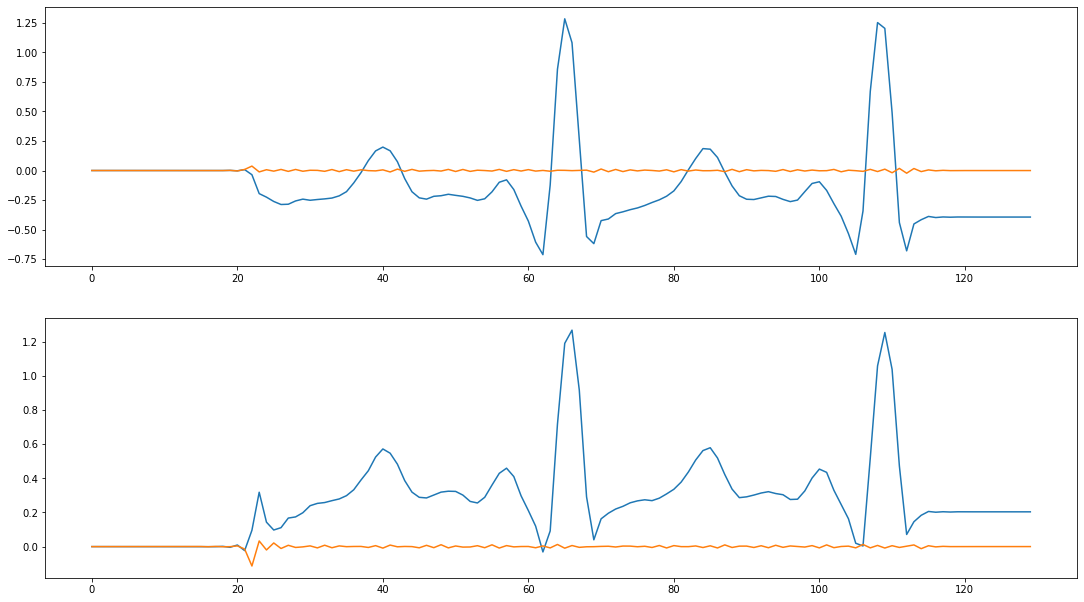

In [9]:
    signal = validation_patches_df.loc["65_0"]
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
  
    
    first_lead = signal['first_lead_dwt_approximation']
    first_lead_d = signal['first_lead_dwt_detail']
    second_lead = signal['second_lead_dwt_approximation']
    second_lead_d = signal['second_lead_dwt_detail']
    
    x = list(range(len(first_lead)))
    
    ax1.plot(x,first_lead)
    ax2.plot(x,second_lead)
    ax1.plot(x,first_lead_d)
    ax2.plot(x,second_lead_d)
    
    plt.show()

In [10]:
def create_input_dwt(df):
    
    x = list()
    y = list()
    
    #	first_lead_dwt_detail		
    for id in tqdm(df.index.tolist()):
        row = df.loc[id]
        x.append(np.transpose(np.asarray([row['first_lead_dwt_approximation'],
                                          row['first_lead_dwt_detail'],
                                          row['second_lead_dwt_approximation'],
                                          row['second_lead_dwt_detail']]).astype(np.float32)))
        y.append(row['label'])

    x = np.asarray(x).astype(np.float32)
    y = np.asarray(y).astype(np.float32)
    
    return x,y

In [11]:
x_train,y_train = create_input_dwt(training_patches_df)
x_valid,y_valid = create_input_dwt(validation_patches_df)

100%|█████████████████████████████████████████████████████████████████████████| 46805/46805 [00:03<00:00, 14090.66it/s]


N: 183817
V: 6127
S: 7587


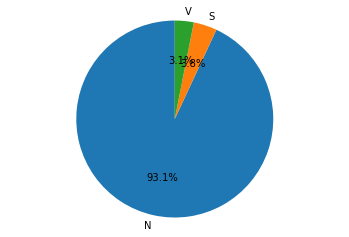

In [ ]:
balanced_df = training_patches_df

ids_n = balanced_df.index[balanced_df['stringLabel'] == 'N'].tolist() 
ids_v = balanced_df.index[balanced_df['stringLabel'] == 'V'].tolist() 
ids_s = balanced_df.index[balanced_df['stringLabel'] == 'S'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()


In [ ]:
training_patches_df.head()

In [12]:
#From lesson 6
def compute_class_freqs(labels):

    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

def compute_weighted_loss_params(y_train):
    freq_pos, freq_neg = compute_class_freqs(y_train)
    print(f"pos freqs: {freq_pos}")

    print(f"neg freqs: {freq_neg}")

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    plot_occ = pd.DataFrame({"Class": classes, "Label": "Positive", "Value": freq_pos})
    plot_occ = plot_occ.append([{"Class": classes[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
    plt.xticks(rotation=90)
    f = sns.barplot(ax = axes[0], x="Class", y="Value", hue="Label" ,data=plot_occ)
    pos_weights = freq_neg
    neg_weights = freq_pos
    pos_contribution = freq_pos * pos_weights 
    neg_contribution = freq_neg * neg_weights
    plot_occ = pd.DataFrame({"Class": classes, "Label": "Positive", "Value": pos_contribution})
    plot_occ = plot_occ.append([{"Class": classes[l], "Label": "Negative", "Value": v} 
                            for l,v in enumerate(neg_contribution)], ignore_index=True)
    plt.xticks(rotation=90)
    sns.barplot(ax = axes[1], x="Class", y="Value", hue="Label" ,data=plot_occ)
    return pos_weights, neg_weights


def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon) 
                             + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon)))
        return loss    
    return weighted_loss

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ecg_signal (InputLayer)        [(None, 130, 4)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 130, 32)      1312        ['ecg_signal[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 130, 32)     128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 130, 32)      0           ['batch_normalization[0][0]']

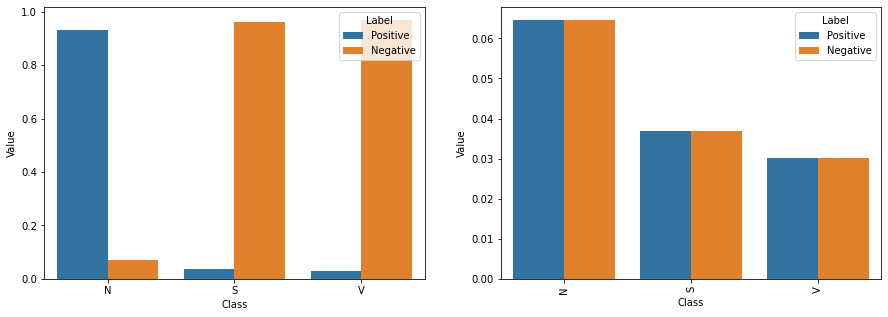

In [13]:
import seaborn as sns
from keras.utils.vis_utils import plot_model
from math import gcd
from sklearn.utils.class_weight import compute_class_weight
import keras.backend as K

batch_size = 64


def ResBs_Conv(block_input, num_filters): 
   
    # 0. Filter Block input and BatchNormalization
    block_input = keras.layers.Conv1D(num_filters, kernel_size=5, strides = 2,  padding = 'same')(block_input) 
    block_input = keras.layers.BatchNormalization()(block_input)

    # 1. First Convolutional Layer
    conv1 = keras.layers.Conv1D(filters=num_filters, kernel_size=5, padding= 'same')(block_input)
    norm1 = keras.layers.BatchNormalization()(conv1)
    relu1 = keras.layers.Activation('relu')(norm1)  
    dropout = keras.layers.Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = keras.layers.Conv1D(num_filters, kernel_size=5, padding= 'same')(dropout) #per avere concordanza
    norm2 = keras.layers.BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = keras.layers.Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = keras.layers.Activation('relu')(sum)
    
    return relu2 

def ResBs_Identity(block_input, num_filters): 

    # 1. First Convolutional Layer
    conv1 = keras.layers.Conv1D(filters=num_filters, kernel_size=5, padding= 'same')(block_input)
    norm1 = keras.layers.BatchNormalization()(conv1)
    relu1 = keras.layers.Activation('relu')(norm1)    
    dropout = keras.layers.Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = keras.layers.Conv1D(num_filters, kernel_size=5, padding= 'same')(dropout) #per avere concordanza
    norm2 = keras.layers.BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = keras.layers.Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = keras.layers.Activation('relu')(sum)
    
    return relu2 

#N= number of blocks in resnet, ch = different channels, win_len = common lenght for ecg signals, classes=..
def resnet(input_shape, N=10, custom_loss = None): 
    ecg_input = keras.layers.Input(shape=input_shape, name='ecg_signal') 

    #ResNet = keras.layers.Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input)
    ResNet = keras.layers.Conv1D(filters=32,kernel_size=10, padding = 'same')(ecg_input) 
    ResNet = keras.layers.BatchNormalization()(ResNet)
    ResNet = keras.layers.Activation('relu')(ResNet)
    ResNet = keras.layers.MaxPooling1D(pool_size=5, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 32)
    ResNet = ResBs_Identity(ResNet, 32)

    filters = 32
    M= int((N -2 )/2)
    for i in range(M): 
        filters = filters*2
        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = keras.layers.GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    #Not necessary?
    ResNet = keras.layers.Flatten()(ResNet) 
    ResNet = keras.layers.Activation('relu')(ResNet)
    ResNet = keras.layers.Flatten()(ResNet) 
    # Sigmoid activation function on the last layer to retrieve all the combination, instead of softmax
    ResNet = keras.layers.Dense(3, activation='softmax',  name='softmax_classifier')(ResNet)

    # Finally the model is composed by connecting inputs to outputs: 
    model = tf.keras.Model(inputs=[ecg_input],outputs=ResNet)

    # summarize layers
    print(model.summary())
    # plot graph
    #plot_model(model, to_file='convolutional_neural_network.png')
    return model

nn= resnet(x_train.shape[1:])

callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10,
    mode="auto",
    restore_best_weights=True,
)

es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,mode="auto", restore_best_weights=True)
pl=ReduceLROnPlateau(monitor='val_loss',patience=4,factor=0.1,verbose=1,min_lr=1e-11)
callbacks = [es,pl]

pos_weights, neg_weights = compute_weighted_loss_params(y_train)
custom_loss = get_weighted_loss(pos_weights, neg_weights)

learning_rate = 1e-6
nn.compile(
    optimizer = 'adam',
    loss = custom_loss,#'categorical_crossentropy',
    metrics = ['Precision', 'Recall'],
    
)
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
                                            class_weight = 'balanced', 
                                            classes = np.unique(y_integers), 
                                            y = y_integers 
                                        )
d_class_weights = dict(enumerate(class_weights))

history = nn.fit(
    x = x_train,
    y = y_train, 
    batch_size = batch_size,
    steps_per_epoch=len(x_train)/batch_size,
    validation_data=(x_valid, y_valid),
    epochs = 100,
    shuffle = True,
    callbacks=[callback],
    class_weight = d_class_weights
).history

#validation_data=(X_val_filt, y_val),

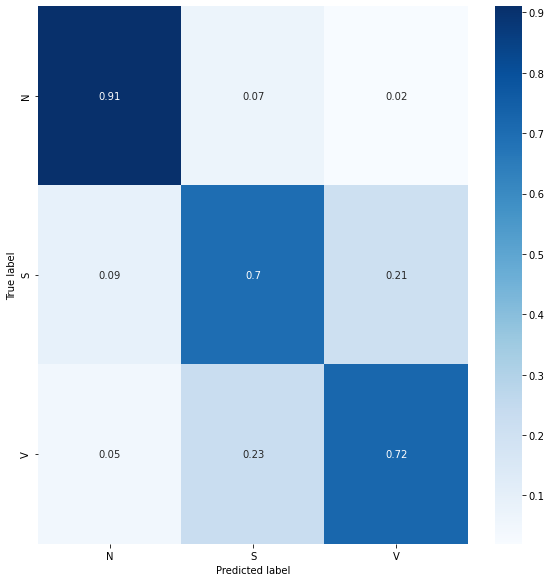

In [14]:

# take also old samples to assess performances 
def plot_confusion_matrix(y_true, y_pred,normalized):
    """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
    """
    con_mat = tf.math.confusion_matrix(labels=y_val_classes, predictions=y_pred).numpy()
    if (normalized):
      con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
      con_mat_df = pd.DataFrame(con_mat_norm,
                      index = classes, 
                      columns = classes)
    else:
        con_mat_df = pd.DataFrame(con_mat,
                      index = classes, 
                      columns = classes)
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return con_mat


print("Making predictions ...",end="\r")

y_pred= nn.predict(x_valid)

y_pred=np.argmax(y_pred,axis=1)
y_val_classes=np.argmax(y_valid, axis=1)

#conf = plot_confusion_matrix(y_val_classes, y_pred,0)
conf = plot_confusion_matrix(y_val_classes, y_pred,1)

In [ ]:
classes = ["N","S","V"]

results = {}

for i,c in enumerate(classes):
    
    results[c] = {}
    
    others = [0,1,2]
    others.remove(i)
    
    results[c]["tp"] = conf[i,i]
    results[c]["fn"] = 0
    results[c]["fp"] = 0
    
    for l in others:
        results[c]["fn"] += conf[i,l]
        results[c]["fp"] += conf[l,i]


sensitivity_n = (results["N"]["tp"])/(results["N"]["tp"]+results["N"]["fn"])
precision_n = (results["N"]["tp"])/(results["N"]["tp"]+results["N"]["fp"])

print(f"sensitivity for N: {sensitivity_n}")
print(f"precision for N: {precision_n}")

sensitivity_s = (results["S"]["tp"])/(results["S"]["tp"]+results["S"]["fn"])
precision_s = (results["S"]["tp"])/(results["S"]["tp"]+results["S"]["fp"])

print(f"sensitivity for S: {sensitivity_s}")
print(f"precision for S: {precision_s}")

sensitivity_v = (results["V"]["tp"])/(results["V"]["tp"]+results["V"]["fn"])
precision_v = (results["V"]["tp"])/(results["V"]["tp"]+results["V"]["fp"])

print(f"sensitivity for V: {sensitivity_v}")
print(f"precision for V: {precision_v}")

sensitivity for N: 0.9402760060303839
precision for N: 0.997784888013783
sensitivity for S: 0.7151335311572701
precision for S: 0.4196169471851422
sensitivity for V: 0.8279376498800959
precision for V: 0.5060461707585197


pos freqs: [0.308805 0.38239  0.308805]
neg freqs: [0.691195 0.61761  0.691195]
Epoch 1/100
155/155 [==============================] - 97s 549ms/step - loss: 10.5943 - precision: 0.3090 - recall: 0.3089 - val_loss: 15.4401 - val_precision: 0.0356 - val_recall: 0.0356
Epoch 2/100
155/155 [==============================] - 84s 542ms/step - loss: 10.6471 - precision: 0.3088 - recall: 0.3088 - val_loss: 15.4401 - val_precision: 0.0356 - val_recall: 0.0356
Epoch 3/100
135/155 [=========================>....] - ETA: 5s - loss: 10.6464 - precision: 0.3089 - recall: 0.3089

KeyboardInterrupt: ignored

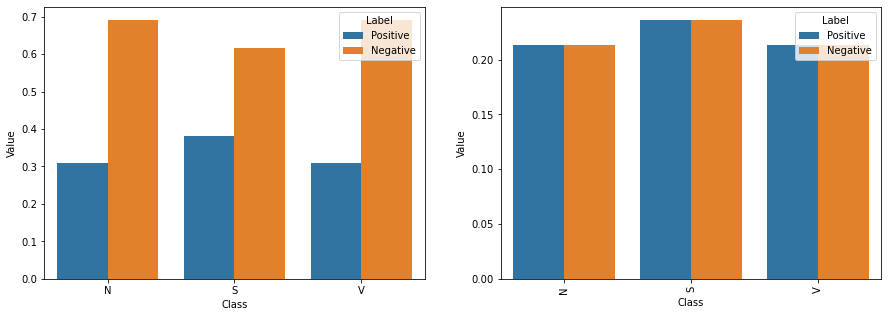

In [ ]:
from keras.initializers import glorot_uniform
import seaborn as sns
from keras.utils.vis_utils import plot_model
from math import gcd
from sklearn.utils.class_weight import compute_class_weight
import keras.backend as K

batch_size = 128

def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = keras.layers.Conv1D(filters=F1, kernel_size=5, strides=s, padding='same', name=conv_name_base + '2a')(X)
    X = keras.layers.BatchNormalization(name=bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv1D(filters=F2, kernel_size=5, padding='same', name=conv_name_base + '2b')(X)
    X = keras.layers.BatchNormalization(name=bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv1D(filters=F3, kernel_size=5, padding='same', name=conv_name_base + '2c')(X)
    X = keras.layers.BatchNormalization(name=bn_name_base + '2c')(X)

    X_shortcut = keras.layers.Conv1D(filters=F3, kernel_size=5, strides=s, padding='same', name=conv_name_base + '1')(X_shortcut)
    X_shortcut = keras.layers.BatchNormalization(name=bn_name_base + '1')(X_shortcut)

    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)

    return X

def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
        
    X = keras.layers.Conv1D(filters=F1, kernel_size=5, strides=1, padding='same', name=conv_name_base + '2a')(X)
    X = keras.layers.BatchNormalization(name=bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv1D(filters=F2, kernel_size=5, strides=1, padding='same', name=conv_name_base + '2b')(X)
    X = keras.layers.BatchNormalization(name=bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv1D(filters=F3, kernel_size=5, strides=1, padding='same', name=conv_name_base + '2c')(X)
    X = keras.layers.BatchNormalization(name=bn_name_base + '2c')(X)

    X = keras.layers.Add()([X, X_shortcut])# SKIP Connection
    X = keras.layers.Activation('relu')(X)

    return X

def ResNet50(patch_length=320):

    X_input = keras.layers.Input(shape=(patch_length,2), name='ecg_signal') 


    X = keras.layers.Conv1D(filters=64,kernel_size=7, padding = 'same')(X_input)
    X = keras.layers.BatchNormalization(name='bn_conv1')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPooling1D(pool_size=3, strides = 2)(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')


    X = keras.layers.AveragePooling1D(pool_size=2, padding='same')(X)
    
    base_model = tf.keras.Model(inputs=X_input, outputs=X, name='ResNet50')

    headModel = base_model.output
    headModel = keras.layers.Flatten()(headModel)
    headModel= keras.layers.Dense(256, activation='relu', name='fc1')(headModel)
    headModel= keras.layers.Dense(128, activation='relu', name='fc2')(headModel)
    headModel = keras.layers.Dense(3, activation='softmax',  name='softmax_classifier')(headModel)
    model = tf.keras.Model(inputs=base_model.input, outputs=headModel)
    return model

nn= ResNet50()

callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10,
    mode="auto",
    restore_best_weights=True,
)

es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,mode="auto", restore_best_weights=True)
pl=ReduceLROnPlateau(monitor='val_loss',patience=4,factor=0.1,verbose=1,min_lr=1e-11)
callbacks = [es,pl]

pos_weights, neg_weights = compute_weighted_loss_params(y_train)
custom_loss = get_weighted_loss(pos_weights, neg_weights)

learning_rate = 1e-3
nn.compile(
    optimizer = 'adam',
    loss = custom_loss,#'categorical_crossentropy',
    metrics = ['Precision', 'Recall'],
    
)
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
                                            class_weight = 'balanced', 
                                            classes = np.unique(y_integers), 
                                            y = y_integers 
                                        )
d_class_weights = dict(enumerate(class_weights))

history = nn.fit(
    x = x_train,
    y = y_train, 
    batch_size = batch_size,
    steps_per_epoch=len(x_train)/batch_size,
    validation_data=(x_valid, y_valid),
    epochs = 100,
    shuffle = True,
    callbacks=[callback],
    class_weight = d_class_weights
).history